In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import statsmodels.api

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# preparing some data: Chilean peso to US dollar vs. copper prices
def get_daily_data_from_stooq(ticker_symbol, start_date, end_date):
    d_1 = start_date.replace("-", "")
    d_2 = end_date.replace("-", "")
    temp_url = "https://stooq.com/q/d/l/?s=" + ticker_symbol + "&d1=" \
               + d_1 + "&d2=" + d_2 + "&i=d"
    print("Getting data from URL: ", temp_url)
    data_in = pd.read_csv(temp_url, usecols=['Date', 'Close'], parse_dates=[0])
    return data_in


data_start_date = "2001-01-01"
data_end_date = "2015-12-31"
temp_ticker_symbol = "usdclp"

data_usdclp = get_daily_data_from_stooq(temp_ticker_symbol, data_start_date,
                                     data_end_date)

temp_ticker_symbol = "hg.f"
data_copper = get_daily_data_from_stooq(temp_ticker_symbol, data_start_date,
                                     data_end_date)

Getting data from URL:  https://stooq.com/q/d/l/?s=usdclp&d1=20010101&d2=20151231&i=d
Getting data from URL:  https://stooq.com/q/d/l/?s=hg.f&d1=20010101&d2=20151231&i=d


In [3]:
# display heads of the dataframes
print(data_usdclp.head())
print(data_copper.head())

        Date   Close
0 2001-01-02  575.28
1 2001-01-03  573.65
2 2001-01-04  571.22
3 2001-01-05  573.47
4 2001-01-08  574.92
        Date  Close
0 2001-01-02  81.15
1 2001-01-03  81.70
2 2001-01-04  81.10
3 2001-01-05  82.45
4 2001-01-08  82.85


In [4]:
# renaming the columns
data_usdclp.rename(columns={'Close': 'usdclp'}, inplace=True)
data_copper.rename(columns={'Close': 'copper'}, inplace=True)

In [5]:
# join the data
data_md = pd.merge(left=data_usdclp, right=data_copper,
                   left_on='Date', right_on='Date',
                   how='outer', sort=True)

In [6]:
# filling in the missing values - order of ffill and bfill is not random
data_md = data_md.set_index('Date')
data_md.fillna(method='ffill', inplace=True)
data_md.fillna(method='bfill', inplace=True)

<IPython.core.display.Javascript object>


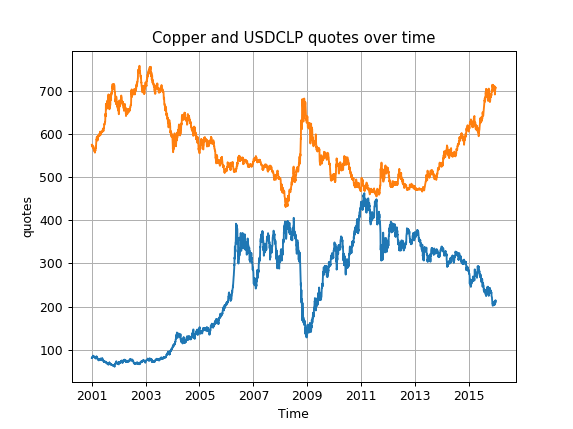

In [7]:
# overview of level plot
fig_joint_plot = plt.figure(1)
axes_joint_plot = fig_joint_plot.add_subplot(1,1,1)
axes_joint_plot.plot(data_md.loc[:,['copper', 'usdclp']])
axes_joint_plot.set_xlabel("Time")
axes_joint_plot.set_ylabel("quotes")
axes_joint_plot.set_title("Copper and USDCLP quotes over time")
axes_joint_plot.grid(True)

<IPython.core.display.Javascript object>


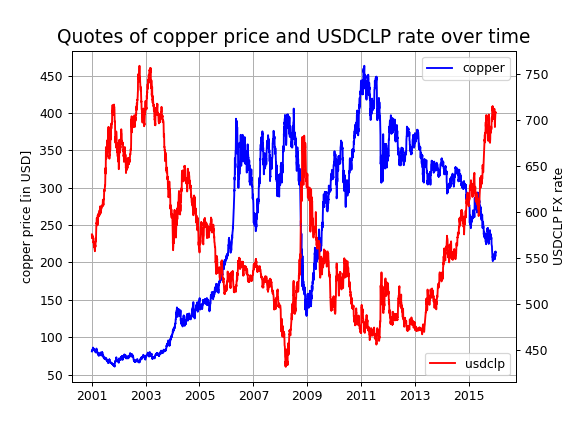

In [8]:
# after a while you might decide that two vertical axes would provide clearer picture...
fig_joint_plot_v2 = plt.figure(2)
axes_joint_plot_v2 = fig_joint_plot_v2.add_subplot(1,1,1)

# make the primary axes and the seconday axes with twinx()
axes_joint_plot_v2.plot(data_md.loc[:, 'copper'], color='blue')
axes_joint_plot_v2.set_ylabel('copper price [in USD]')
axes_joint_plot_v2_twin = axes_joint_plot_v2.twinx()
axes_joint_plot_v2.grid(True)

# make secondary plot
axes_joint_plot_v2_twin.plot(data_md.loc[:, 'usdclp'], color='red')
axes_joint_plot_v2_twin.set_ylabel('USDCLP FX rate')

# add legend & title
axes_joint_plot_v2_twin.legend(loc='lower right')
axes_joint_plot_v2.legend(loc='upper right')
axes_joint_plot_v2.set_title("Quotes of copper price and USDCLP rate over time", fontsize=15)

In [9]:
# obviously, these time series are not stationary, but let's check this formally
res_adftest_copper = statsmodels.tsa.stattools.adfuller(data_md.loc[:, 'copper'], maxlag=1)
res_adftest_usdclp = statsmodels.tsa.stattools.adfuller(data_md.loc[:, 'usdclp'], maxlag=1)
print("p-value for ADF test for copper: ", str(round(res_adftest_copper[1],2)))
print("p-value for ADF test for usdclp: ", str(round(res_adftest_usdclp[1],2)))

p-value for ADF test for copper:  0.48
p-value for ADF test for usdclp:  0.71


In [10]:
# in both cases there is no reason ro reject the null hypothesis that says that there is a unit root
# Consequently, let's calculate log returns and work on them
data_md.loc[:,'logrr_copper'] = np.log(data_md.loc[:,'copper']).diff(1)
data_md.loc[:,'logrr_usdclp'] = np.log(data_md.loc[:,'usdclp']).diff(1)
print(data_md.head())

            usdclp  copper  logrr_copper  logrr_usdclp
Date                                                  
2001-01-02  575.28   81.15           NaN           NaN
2001-01-03  573.65   81.70      0.006755     -0.002837
2001-01-04  571.22   81.10     -0.007371     -0.004245
2001-01-05  573.47   82.45      0.016509      0.003931
2001-01-08  574.92   82.85      0.004840      0.002525


<IPython.core.display.Javascript object>


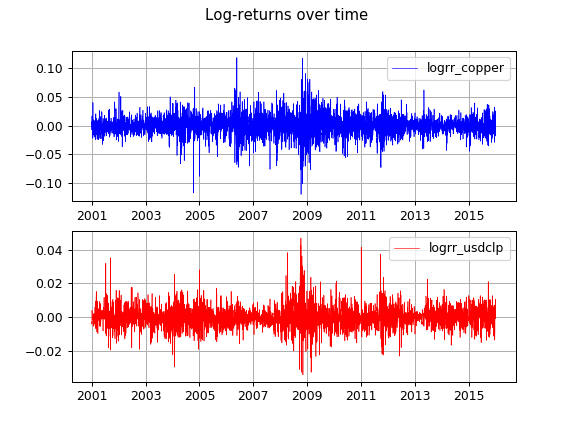

In [11]:
# a plot of log return
logrr_plot = plt.figure(3)
subplot_logrr_copper = logrr_plot.add_subplot(2,1,1)
subplot_logrr_usdclp = logrr_plot.add_subplot(2,1,2)

subplot_logrr_copper.plot(data_md.loc[:, 'logrr_copper'], color='blue', linewidth=0.5)
subplot_logrr_copper.grid(True)
subplot_logrr_copper.legend()

subplot_logrr_usdclp.plot(data_md.loc[:, 'logrr_usdclp'], color='red', linewidth=0.5)
subplot_logrr_usdclp.grid(True)
subplot_logrr_usdclp.legend()


# add title
logrr_plot.suptitle("Log-returns over time")

<IPython.core.display.Javascript object>


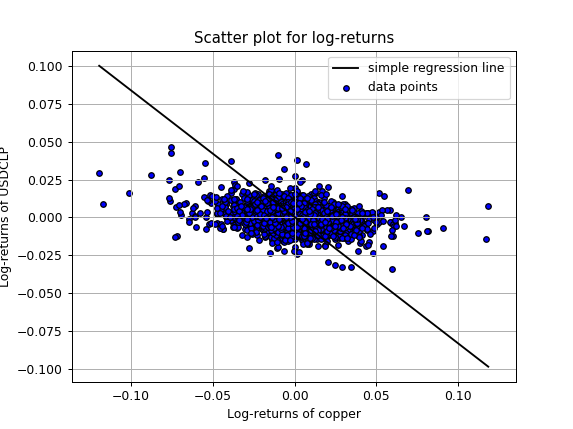

In [29]:
# now, let's plot a scatter plot with copper on the X axis
scatter_axes = data_md.plot(kind='scatter', x='logrr_copper', y='logrr_usdclp', 
                            edgecolor='black', color='blue', label='data points')
scatter_axes.set_xlabel("Log-returns of copper")
scatter_axes.set_ylabel("Log-returns of USDCLP")
scatter_axes.grid(True)
scatter_axes.set_title("Scatter plot for log-returns")
# and fit a simple regression line to the plot: dependent - USDCLP, regressor - copper price
vec_dep = data_md.loc[:, 'logrr_copper'].dropna()
vec_regrsr = data_md.loc[:, 'logrr_usdclp'].dropna()
[slope_coeff, intercept_coeff] = np.polyfit(vec_regrsr, vec_dep, 1)
# prepare a range for the line being fitted to the plot
line_xvals = np.linspace(vec_dep.min(), vec_dep.max(), 300)
line_yvals = slope_coeff*line_xvals + intercept_coeff
plt.plot(line_xvals, line_yvals, color='black', label='simple regression line')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


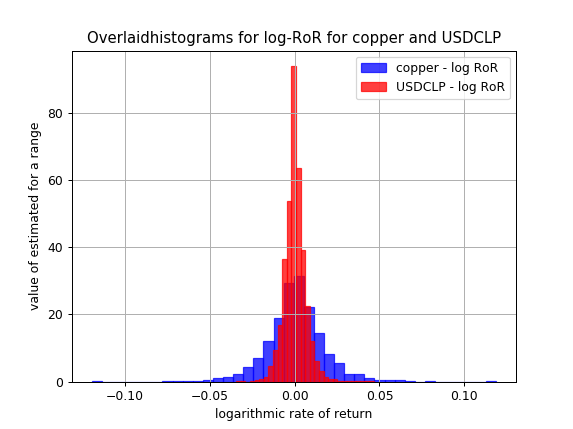

In [37]:
# overlaid histograms of returns for the two time series
figure_overlaid_histograms = plt.figure(5)
axes_overlaid_histograms = figure_overlaid_histograms.add_subplot(1,1,1)
axes_overlaid_histograms.hist(data_md.loc[:, 'logrr_copper'].dropna(),
                                                          bins=40, color='blue', edgecolor='blue',
                                                          label='copper - log RoR', normed=True, alpha=0.75)
axes_overlaid_histograms.hist(data_md.loc[:, 'logrr_usdclp'].dropna(),
                                                          bins=30, color='red', edgecolor='red',
                                                          label='USDCLP - log RoR', normed=True, alpha=0.75)

axes_overlaid_histograms.legend(loc='upper right')
axes_overlaid_histograms.set_xlabel('logarithmic rate of return')
axes_overlaid_histograms.set_ylabel('value of estimated for a range')
axes_overlaid_histograms.set_title('Overlaidhistograms for log-RoR for copper and USDCLP')
axes_overlaid_histograms.grid(True)

<IPython.core.display.Javascript object>


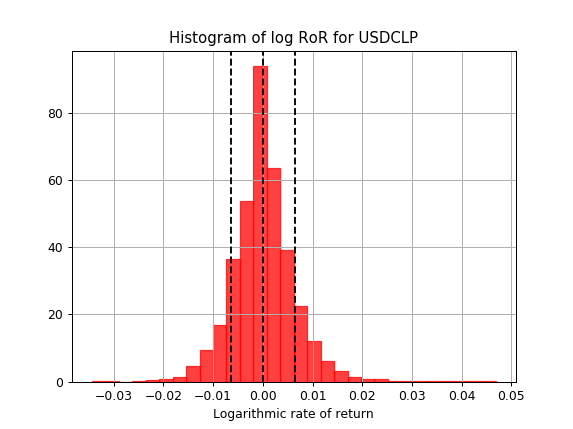

Some descriptive statistics for the time series of log-RoR of USDCLP: 
	Mean:  5.337846281757203e-05
	Standard deviation:  0.006386616109514987
	Skew:  0.47565734549014443
	Kurtosis:  4.619129452393275
	Median:  0.0
	Min:  -0.03440679884519682
	Max:  0.04683818545067542


In [52]:
# individual histograms with some descriptive statistics
hist_indiv_fig_usdclp = plt.figure('hist_indiv_fig_usdclp')
hist_indiv_axes_usdclp = hist_indiv_fig_usdclp.add_subplot(1, 1, 1)
hist_indiv_axes_usdclp.hist(data_md.loc[:, 'logrr_usdclp'].dropna(), bins=30, color='red', edgecolor='red',
                           alpha=0.75, normed=True)
hist_indiv_axes_usdclp.grid(True)
hist_indiv_axes_usdclp.set_title("Histogram of log RoR for USDCLP")
hist_indiv_axes_usdclp.set_xlabel("Logarithmic rate of return")

print("Some descriptive statistics for the time series of log-RoR of USDCLP: ")
print("\tMean: ", float(data_md.loc[:, 'logrr_usdclp'].mean()))
print("\tStandard deviation: ", float(data_md.loc[:, 'logrr_usdclp'].std()))
print("\tSkew: ", float(data_md.loc[:, 'logrr_usdclp'].skew()))
print("\tKurtosis: ", float(data_md.loc[:, 'logrr_usdclp'].kurt()))
print("\tMedian: ", float(data_md.loc[:, 'logrr_usdclp'].median()))
print("\tMin: ", float(data_md.loc[:, 'logrr_usdclp'].min()))
print("\tMax: ", float(data_md.loc[:, 'logrr_usdclp'].max()))

# adding vertical line at mean, mean+std, mean-std
hist_indiv_axes_usdclp.axvline(data_md.loc[:, 'logrr_usdclp'].mean(), color='black', linestyle='dashed')
hist_indiv_axes_usdclp.axvline(data_md.loc[:, 'logrr_usdclp'].mean() + data_md.loc[:, 'logrr_usdclp'].std()
                               , color='black', linestyle='dashed')
hist_indiv_axes_usdclp.axvline(data_md.loc[:, 'logrr_usdclp'].mean() - data_md.loc[:, 'logrr_usdclp'].std()
                               , color='black', linestyle='dashed')

<IPython.core.display.Javascript object>


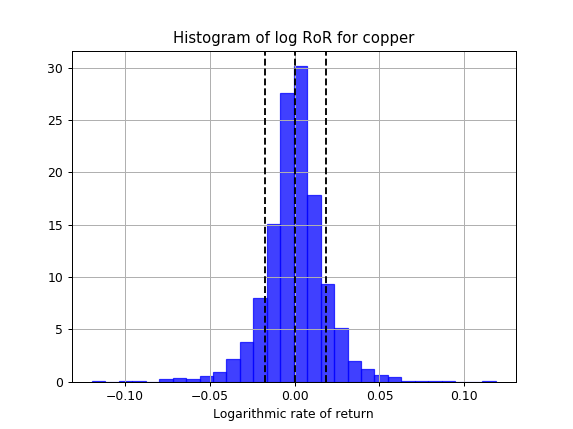

Some descriptive statistics for the time series of log-RoR of copper prices: 
	Mean:  0.00024911346541195347
	Standard deviation:  0.017989777486757747
	Skew:  -0.16383085845211268
	Kurtosis:  4.31355012390756
	Median:  0.0
	Min:  -0.11957480180395574
	Max:  0.11850584016923982


In [53]:
# individual histograms with some descriptive statistics
hist_indiv_fig_copper = plt.figure('hist_indiv_fig_copper')
hist_indiv_axes_copper = hist_indiv_fig_copper.add_subplot(1, 1, 1)
hist_indiv_axes_copper.hist(data_md.loc[:, 'logrr_copper'].dropna(), bins=30, color='blue', edgecolor='blue',
                           alpha=0.75, normed=True)
hist_indiv_axes_copper.grid(True)
hist_indiv_axes_copper.set_title("Histogram of log RoR for copper")
hist_indiv_axes_copper.set_xlabel("Logarithmic rate of return")

print("Some descriptive statistics for the time series of log-RoR of copper prices: ")
print("\tMean: ", float(data_md.loc[:, 'logrr_copper'].mean()))
print("\tStandard deviation: ", float(data_md.loc[:, 'logrr_copper'].std()))
print("\tSkew: ", float(data_md.loc[:, 'logrr_copper'].skew()))
print("\tKurtosis: ", float(data_md.loc[:, 'logrr_copper'].kurt()))
print("\tMedian: ", float(data_md.loc[:, 'logrr_copper'].median()))
print("\tMin: ", float(data_md.loc[:, 'logrr_copper'].min()))
print("\tMax: ", float(data_md.loc[:, 'logrr_copper'].max()))

# adding vertical line at mean, mean+std, mean-std
hist_indiv_axes_copper.axvline(data_md.loc[:, 'logrr_copper'].mean(), color='black', linestyle='dashed')
hist_indiv_axes_copper.axvline(data_md.loc[:, 'logrr_copper'].mean() + data_md.loc[:, 'logrr_copper'].std()
                               , color='black', linestyle='dashed')
hist_indiv_axes_copper.axvline(data_md.loc[:, 'logrr_copper'].mean() - data_md.loc[:, 'logrr_copper'].std()
                               , color='black', linestyle='dashed')